In [ ]:
import pandas as pd
import pyarrow
import numpy as np
from scipy.spatial.distance import jensenshannon

In [3]:
work_languages_df = pd.read_parquet(
    '/run/media/rares17/f15020b9-f291-4fe9-85f0-e6bd87520125/thesis/bookdata-tools/book-links/deduced_languages.parquet',
    engine='pyarrow')  # or engine='fastparquet'
work_languages_df

,work_id,deduced_language
0,13595490,eng-original
1,28069067,other-translation-not-found
2,6832578,other-translated
3,26085788,unknown
4,16947674,eng-original
...,...,...
1521957,196000,unknown
1521958,1280700,eng-original
1521959,47330041,unknown
1521960,301191,eng-original


In [3]:
work_ratings_df = pd.read_parquet(
    '/run/media/rares17/f15020b9-f291-4fe9-85f0-e6bd87520125/thesis/bookdata-tools/goodreads/gr-work-ratings.parquet',
    engine='pyarrow')
work_ratings_df

,user,item,rating,last_rating,first_time,last_time,nratings
0,1,400625995,3.0,3.0,1501432064,1501432064,1
1,1,400033362,4.0,4.0,1495825408,1495825408,1
2,1,400985244,2.0,2.0,1490208512,1490208512,1
3,1,450247128,5.0,5.0,1488877696,1488877696,1
4,1,447250922,4.0,4.0,1482852608,1482852608,1
...,...,...,...,...,...,...,...
104028924,876145,403410520,3.0,3.0,1366579328,1366579328,1
104028925,876145,404812169,4.0,4.0,1366579328,1366579328,1
104028926,876145,421956106,3.0,3.0,1366579328,1366579328,1
104028927,876145,413086736,4.0,4.0,1367538688,1367538688,1


In [12]:
work_ratings_df['user'].value_counts()

user
320563    38402
257875    17183
69819     14137
438895    13018
56066     12980
          ...  
865768        1
872426        1
872405        1
872344        1
872328        1
Name: count, Length: 816371, dtype: int64

Nr. of users with 5 books read: 750205
Nr. of users with 10 books read: 701732


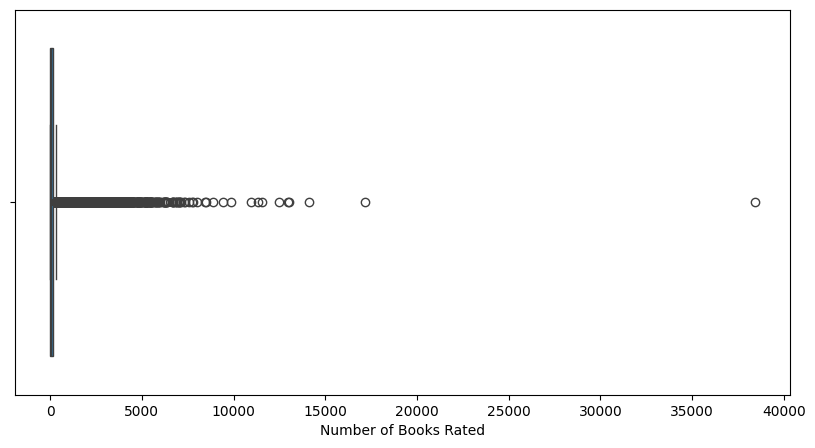

In [5]:
# check how many users have more than 5 and 10 books rated
user_counts = work_ratings_df['user'].value_counts()
# Filter out outlier users

print(f"Nr. of users with 5 books read: {len(user_counts[user_counts >= 5].index)}")
print(f"Nr. of users with 10 books read: {len(user_counts[user_counts >= 10].index)}")

import seaborn as sns
import matplotlib.pyplot as plt
# Create a boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=user_counts)

# Labeling
plt.xlabel("Number of Books Rated")

plt.show()

In [6]:
filtered_users = user_counts[user_counts <= 2500].index
filtered_df = work_ratings_df[work_ratings_df['user'].isin(filtered_users)]

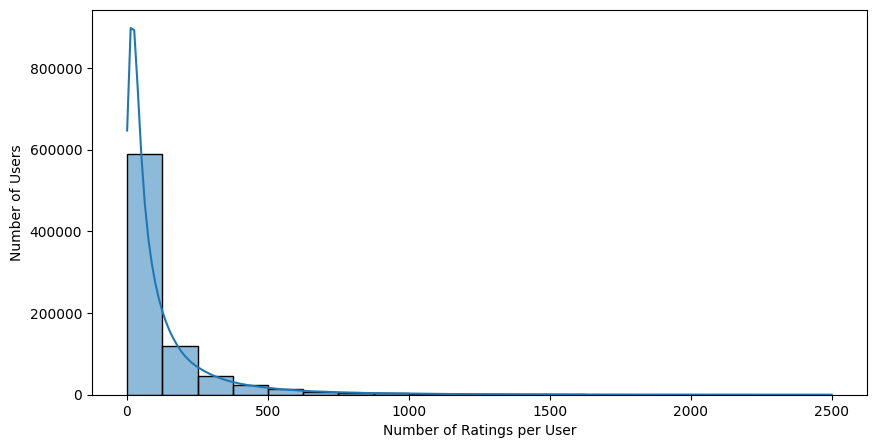

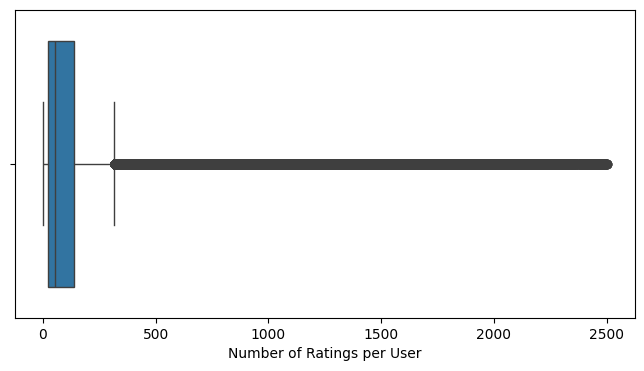

In [8]:

user_rating_counts = filtered_df.groupby('user').size()

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(user_rating_counts, bins=20, kde=True)
plt.xlabel("Number of Ratings per User")
plt.ylabel("Number of Users")
plt.show()


# Plot boxplot to see outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=user_rating_counts)
plt.xlabel("Number of Ratings per User")
plt.show()


In [17]:
Q1 = user_counts.quantile(0.15)
Q3 = user_counts.quantile(0.85)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

mean_count = user_counts.mean()
median_count = user_counts.median()
std_dev = user_counts.std()
max_count = user_counts.max()

print(f"Mean: {mean_count:.2f}, Median: {median_count:.2f}, Std Dev: {std_dev:.2f}")
print(f"Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
print(f"Outlier threshold (Q3 + 1.5*IQR): {upper_bound:.2f}")
print(f"Max Ratings by a Single User: {max_count}")


Mean: 127.43, Median: 55.00, Std Dev: 236.36
Q1: 11.00, Q3: 226.00, IQR: 215.00
Outlier threshold (Q3 + 1.5*IQR): 548.50
Max Ratings by a Single User: 38402


In [3]:
gr_ratings_languages_df = pd.read_parquet(
    '/run/media/rares17/f15020b9-f291-4fe9-85f0-e6bd87520125/thesis/bookdata-tools/book-links/gr-item-rating-language.parquet',
    engine='pyarrow')
gr_ratings_languages_df

,user,item,rating,deduced_language
0,1,400625995,3,ambiguous
1,1,400033362,4,other-translated
2,1,400985244,2,other-translated
3,1,450247128,5,other-translated
4,1,447250922,4,other-translated
...,...,...,...,...
104028924,876145,403410520,3,unknown
104028925,876145,404812169,4,other-translation-not-found
104028926,876145,421956106,3,other-translation-not-found
104028927,876145,413086736,4,unknown


In [4]:
user_counts = gr_ratings_languages_df['user'].value_counts()
filtered_users = user_counts[(user_counts >= 11) & (user_counts <= 2500)].index
filtered_users

Index([368439, 345286,  62459, 155965, 224232, 158821, 136908, 116293, 305401,
       108445,
       ...
       825562, 851298, 663283, 861916, 454814, 743551, 840645, 629916, 778599,
       717952],
      dtype='uint32', name='user', length=693572)

In [5]:
gr_ratings_languages_df = gr_ratings_languages_df[gr_ratings_languages_df['user'].isin(filtered_users)]
gr_ratings_languages_df

,user,item,rating,deduced_language
0,1,400625995,3,ambiguous
1,1,400033362,4,other-translated
2,1,400985244,2,other-translated
3,1,450247128,5,other-translated
4,1,447250922,4,other-translated
...,...,...,...,...
104028924,876145,403410520,3,unknown
104028925,876145,404812169,4,other-translation-not-found
104028926,876145,421956106,3,other-translation-not-found
104028927,876145,413086736,4,unknown


In [6]:
language_counts = gr_ratings_languages_df.groupby(['user', 'deduced_language']).size().reset_index(name='count')
language_counts

,user,deduced_language,count
0,1,ambiguous,169
1,1,eng-original,120
2,1,other-translated,175
3,1,unknown,8
4,2,ambiguous,34
...,...,...,...
2784524,876145,ambiguous,1
2784525,876145,eng-original,1
2784526,876145,other-translated,6
2784527,876145,other-translation-not-found,13


In [7]:
total_counts = gr_ratings_languages_df.groupby('user').size().reset_index(name='total')
total_counts

,user,total
0,1,472
1,2,99
2,3,190
3,4,41
4,5,176
...,...,...
693567,876141,11
693568,876142,11
693569,876143,32
693570,876144,23


In [8]:
del gr_ratings_languages_df

In [9]:
language_ratios = language_counts.merge(total_counts, on='user')
language_ratios['ratio'] = language_ratios['count'] / language_ratios['total']

pivot_ratios = language_ratios.pivot(index='user', columns='deduced_language', values='ratio').fillna(0)
pivot_ratios

deduced_language,ambiguous,eng-original,other-translated,other-translation-not-found,unknown
user,,,,,
1,0.358051,0.254237,0.370763,0.000000,0.016949
2,0.343434,0.232323,0.282828,0.000000,0.141414
3,0.252632,0.300000,0.447368,0.000000,0.000000
4,0.170732,0.390244,0.414634,0.000000,0.024390
5,0.232955,0.215909,0.528409,0.000000,0.022727
...,...,...,...,...,...
876141,0.454545,0.272727,0.272727,0.000000,0.000000
876142,0.363636,0.272727,0.363636,0.000000,0.000000
876143,0.562500,0.062500,0.375000,0.000000,0.000000


In [10]:
reference_proportions = np.array([0.016962, 0.319142, 0.091811, 0.031959, 0.540126]) # ambiguous eng-org other-translated other-translation-not-found unknown
pivot_ratios = pivot_ratios[['ambiguous', 'eng-original', 'other-translated', 'other-translation-not-found', 'unknown']]
pivot_ratios

deduced_language,ambiguous,eng-original,other-translated,other-translation-not-found,unknown
user,,,,,
1,0.358051,0.254237,0.370763,0.000000,0.016949
2,0.343434,0.232323,0.282828,0.000000,0.141414
3,0.252632,0.300000,0.447368,0.000000,0.000000
4,0.170732,0.390244,0.414634,0.000000,0.024390
5,0.232955,0.215909,0.528409,0.000000,0.022727
...,...,...,...,...,...
876141,0.454545,0.272727,0.272727,0.000000,0.000000
876142,0.363636,0.272727,0.363636,0.000000,0.000000
876143,0.562500,0.062500,0.375000,0.000000,0.000000


In [11]:
js_divergences = pivot_ratios.apply(lambda row: jensenshannon(row, reference_proportions, base=2), axis=1)
js_divergences

user
1         0.667178
2         0.527601
3         0.683722
4         0.601165
5         0.662360
            ...   
876141    0.710127
876142    0.700171
876143    0.809356
876144    0.634398
876145    0.478790
Length: 693572, dtype: float64

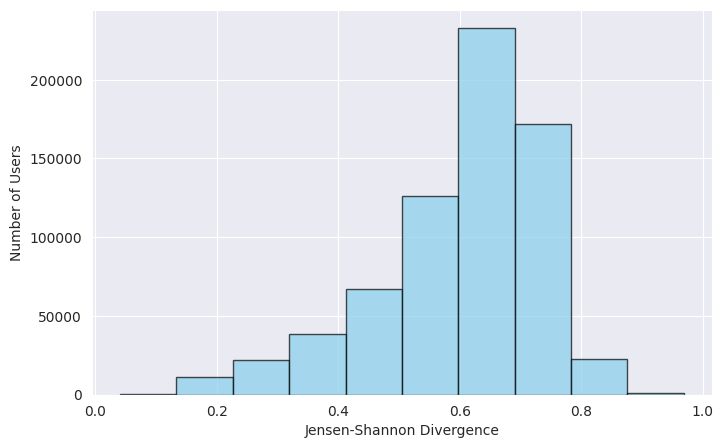

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(js_divergences, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel("Jensen-Shannon Divergence")
plt.ylabel("Number of Users")
# plt.title("JS Divergence Between User Language Ratios and Reference")
plt.show()

In [4]:
import pandas as pd

gr_ratings_languages_df = pd.read_parquet(
    '/run/media/rares17/f15020b9-f291-4fe9-85f0-e6bd87520125/thesis/bookdata-tools/book-links/gr-item-rating-language.parquet',
    engine='pyarrow')
gr_ratings_languages_df

,user,item,rating,deduced_language
0,1,400625995,3,ambiguous
1,1,400033362,4,other-translated
2,1,400985244,2,other-translated
3,1,450247128,5,other-translated
4,1,447250922,4,other-translated
...,...,...,...,...
104028924,876145,403410520,3,unknown
104028925,876145,404812169,4,other-translation-not-found
104028926,876145,421956106,3,other-translation-not-found
104028927,876145,413086736,4,unknown


In [3]:
item_languages = gr_ratings_languages_df[['item', 'deduced_language']].drop_duplicates(subset=['item'])
item_languages

,item,deduced_language
0,400625995,ambiguous
1,400033362,other-translated
2,400985244,other-translated
3,450247128,other-translated
4,447250922,other-translated
...,...,...
104028889,442470426,unknown
104028890,442462401,unknown
104028891,432387599,unknown
104028892,426344906,unknown


In [4]:
language_mapping = {
    'unknown': 4,
    'ambiguous': 3,
    'other-translation-not-found': 2,
    'other-translated': 1,
    'eng-original': 0
}
item_languages['deduced_language'] = item_languages['deduced_language'].replace(language_mapping)
item_languages

/tmp/ipykernel_33404/2840113863.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  item_languages['deduced_language'] = item_languages['deduced_language'].replace(language_mapping)


,item,deduced_language
0,400625995,3
1,400033362,1
2,400985244,1
3,450247128,1
4,447250922,1
...,...,...
104028889,442470426,4
104028890,442462401,4
104028891,432387599,4
104028892,426344906,4


In [5]:

# Save to TSV
item_languages.to_csv('language.tsv', sep='\t', index=False, header=False)

In [5]:
ratings_df = work_ratings_df[['user', 'item', 'rating', 'last_time']]
ratings_df

,user,item,rating,last_time
0,1,400625995,3.0,1501432064
1,1,400033362,4.0,1495825408
2,1,400985244,2.0,1490208512
3,1,450247128,5.0,1488877696
4,1,447250922,4.0,1482852608
...,...,...,...,...
104028924,876145,403410520,3.0,1366579328
104028925,876145,404812169,4.0,1366579328
104028926,876145,421956106,3.0,1366579328
104028927,876145,413086736,4.0,1367538688


In [6]:
if ratings_df['last_time'].isna().any():
    print("NaN values detected. Replacing with an empty string.")
    ratings_df['last_time'] = ratings_df['last_time'].fillna("")

In [18]:
# keep users that have 11 to 2500 ratings
user_counts = ratings_df['user'].value_counts()
filtered_users = user_counts[(user_counts >= 11) & (user_counts <= 2500)].index
filtered_users

Index([368439, 345286,  62459, 155965, 224232, 158821, 136908, 116293, 305401,
       108445,
       ...
       825562, 851298, 663283, 861916, 454814, 743551, 840645, 629916, 778599,
       717952],
      dtype='int32', name='user', length=693572)

In [7]:
# remove items with less than 20 ratings
item_counts = ratings_df['item'].value_counts()
items_to_keep = item_counts[item_counts >= 20].index
ratings_df = ratings_df[ratings_df['item'].isin(items_to_keep)]
ratings_df

,user,item,rating,last_time
0,1,400625995,3.0,1501432064
1,1,400033362,4.0,1495825408
2,1,400985244,2.0,1490208512
3,1,450247128,5.0,1488877696
4,1,447250922,4.0,1482852608
...,...,...,...,...
104028924,876145,403410520,3.0,1366579328
104028925,876145,404812169,4.0,1366579328
104028926,876145,421956106,3.0,1366579328
104028927,876145,413086736,4.0,1367538688


In [8]:
# keep users with more than 20 ratings
user_counts = ratings_df['user'].value_counts()
filtered_users = user_counts[user_counts >= 20].index
filtered_users

Index([320563, 280676, 438895,  72945,  69819,  92144,  32800, 128864, 359400,
       298475,
       ...
       680402, 680392, 646875, 820338, 603220, 651881, 820390, 560305, 799950,
       560330],
      dtype='int32', name='user', length=631019)

In [9]:
ratings_df = ratings_df[ratings_df['user'].isin(filtered_users)]
ratings_df

,user,item,rating,last_time
0,1,400625995,3.0,1501432064
1,1,400033362,4.0,1495825408
2,1,400985244,2.0,1490208512
3,1,450247128,5.0,1488877696
4,1,447250922,4.0,1482852608
...,...,...,...,...
104028924,876145,403410520,3.0,1366579328
104028925,876145,404812169,4.0,1366579328
104028926,876145,421956106,3.0,1366579328
104028927,876145,413086736,4.0,1367538688


In [14]:
ratings_df.to_csv('ratings_11_2500.tsv', sep='\t', index=False, header=False)

In [10]:
# convert ratings to binary
ratings_df['rating'] = (ratings_df['rating'] >= 3).astype(int)
ratings_df

/tmp/ipykernel_6815/3959838055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['rating'] = (ratings_df['rating'] >= 3).astype(int)


,user,item,rating,last_time
0,1,400625995,1,1501432064
1,1,400033362,1,1495825408
2,1,400985244,0,1490208512
3,1,450247128,1,1488877696
4,1,447250922,1,1482852608
...,...,...,...,...
104028924,876145,403410520,1,1366579328
104028925,876145,404812169,1,1366579328
104028926,876145,421956106,1,1366579328
104028927,876145,413086736,1,1367538688


In [11]:
# save so that ratings_df does not have to be recomputed again ( a lot of RAM is needed for the next step)
ratings_df.to_parquet("ratings_20users_20items_binary.parquet")

In [1]:
import pandas as pd
# checkpoint
ratings_df = pd.read_parquet(
    'ratings_20users_20items_binary.parquet',
    engine='pyarrow')
ratings_df

,user,item,rating,last_time
0,1,400625995,1,1501432064
1,1,400033362,1,1495825408
2,1,400985244,0,1490208512
3,1,450247128,1,1488877696
4,1,447250922,1,1482852608
...,...,...,...,...
104028924,876145,403410520,1,1366579328
104028925,876145,404812169,1,1366579328
104028926,876145,421956106,1,1366579328
104028927,876145,413086736,1,1367538688


In [2]:
# split 80% - 20%
train_data = []
val_data = []
test_data = []
count = 0
for user, user_df in ratings_df.groupby('user'):
    count += 1
    user_df = user_df.sort_values(by='last_time')

    train_idx = int(len(user_df) * 0.6)
    val_idx = int(len(user_df) * 0.8)

    train_data.append(user_df.iloc[:train_idx])  # oldest 60%
    val_data.append(user_df.iloc[train_idx:val_idx])
    test_data.append(user_df.iloc[val_idx:])   # newest 20%
    if count % 10000 == 0:
        print(f"Parsed {count} users")

train_df = pd.concat(train_data)
print(train_df)
valid_df = pd.concat(val_data)
print(valid_df)
test_df = pd.concat(test_data)
print(test_df)

Parsed 10000 users
Parsed 20000 users
Parsed 30000 users
Parsed 40000 users
Parsed 50000 users
Parsed 60000 users
Parsed 70000 users
Parsed 80000 users
Parsed 90000 users
Parsed 100000 users
Parsed 110000 users
Parsed 120000 users
Parsed 130000 users
Parsed 140000 users
Parsed 150000 users
Parsed 160000 users
Parsed 170000 users
Parsed 180000 users
Parsed 190000 users
Parsed 200000 users
Parsed 210000 users
Parsed 220000 users
Parsed 230000 users
Parsed 240000 users
Parsed 250000 users
Parsed 260000 users
Parsed 270000 users
Parsed 280000 users
Parsed 290000 users
Parsed 300000 users
Parsed 310000 users
Parsed 320000 users
Parsed 330000 users
Parsed 340000 users
Parsed 350000 users
Parsed 360000 users
Parsed 370000 users
Parsed 380000 users
Parsed 390000 users
Parsed 400000 users
Parsed 410000 users
Parsed 420000 users
Parsed 430000 users
Parsed 440000 users
Parsed 450000 users
Parsed 460000 users
Parsed 470000 users
Parsed 480000 users
Parsed 490000 users
Parsed 500000 users
Parsed 51

In [3]:
# save data sets as is
train_df.to_csv("ratings_20users_20items_split/train_dataset_separated.tsv", sep='\t', index=False, header=False)
valid_df.to_csv("ratings_20users_20items_split/validation_dataset.tsv", sep='\t', index=False, header=False)
test_df.to_csv("ratings_20users_20items_split/test_dataset.tsv", sep='\t', index=False, header=False)
# save complete test set
valid_df.to_csv("ratings_20users_20items_split/train_dataset.tsv", sep='\t', index=False, header=False)
train_df.to_csv("ratinegs_20users_20items_split/train_dataset.tsv", sep='\t', index=False, header=False, mode='a')